In [4]:
!git clone https://github.com/adi9820/Distracted-Driver-Detection

Cloning into 'Distracted-Driver-Detection'...
remote: Enumerating objects: 22455, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22455 (delta 3), reused 16 (delta 1), pack-reused 22437
Receiving objects: 100% (22455/22455), 906.37 MiB | 38.86 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (22435/22435), done.


In [5]:
import numpy as np
import pandas as pd

In [6]:
# setting up the data paths

train_dir = '/content/Distracted-Driver-Detection/train'  # train directory
example_dir = '/content/Distracted-Driver-Detection/example' # example directory

df = pd.read_csv('/content/Distracted-Driver-Detection/driver_imgs_list.csv')   # driver images list csv

In [7]:
# unique classes
classes = df['classname'].unique()
classes

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [8]:
!pip install split-folders

In [10]:
# split data into train and validation
import splitfolders

splitfolders.ratio(train_dir, output="dataa", seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [00:09, 2310.48 files/s]


In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from keras.applications.resnet import ResNet50

In [12]:
device = torch.device("cuda:0")

In [13]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [14]:
training_data = datasets.ImageFolder(root = '/content/dataa/train', transform = transform)

validation_data = datasets.ImageFolder(root = '/content/dataa/val', transform = transform)

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=32, shuffle=True, drop_last=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

In [16]:
from tqdm import tqdm
import time

In [17]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):

    losses = []
    accuracies = []
    val_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.3f, acc: %.3f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode to evaluate on test data
        model.eval()
        val_acc = eval_model(model)
        val_accuracies.append(val_acc)

        # re-set the model to train mode after validating
        model.train()
        scheduler.step(val_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, val_accuracies

In [18]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the validation images: %.2f %%' % (
        test_acc))
    return test_acc

In [19]:
model_ft = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [20]:
model_ft, training_losses, training_accs, val_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, duration: 600 s, loss: 0.360, acc: 88.831


 20%|██        | 1/5 [10:54<43:38, 654.59s/it]

Accuracy of the network on the validation images: 98.93 %
Epoch 2, duration: 609 s, loss: 0.028, acc: 99.148


 40%|████      | 2/5 [21:56<32:57, 659.14s/it]

Accuracy of the network on the validation images: 99.31 %
Epoch 3, duration: 609 s, loss: 0.016, acc: 99.437


 60%|██████    | 3/5 [32:59<22:01, 660.66s/it]

Accuracy of the network on the validation images: 99.67 %
Epoch 4, duration: 610 s, loss: 0.006, acc: 99.738


 80%|████████  | 4/5 [44:03<11:02, 662.14s/it]

Accuracy of the network on the validation images: 99.58 %
Epoch 5, duration: 609 s, loss: 0.002, acc: 99.850


100%|██████████| 5/5 [55:08<00:00, 661.61s/it]

Accuracy of the network on the validation images: 99.73 %
Finished Training


In [21]:
torch.save(model_ft,"modelresnet50.hd5")
torch.save(model_ft.state_dict(), "modelresnet50-driver")

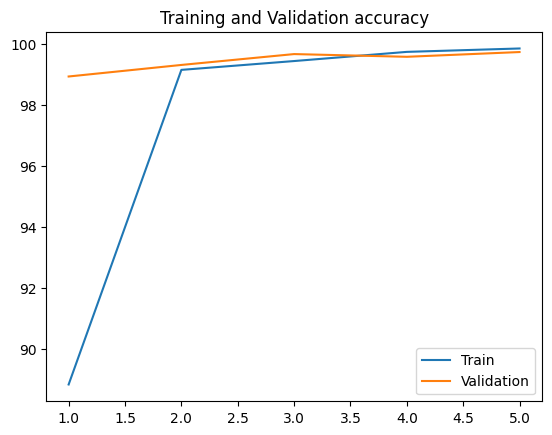

In [22]:
import matplotlib.pyplot as plt

tr_accuracy_resnet = training_accs
val_accuracy_resnet = val_accs

epchs = list(range(1,len(tr_accuracy_resnet)+1))
plt.plot(epchs,tr_accuracy_resnet,label='Train')
plt.plot(epchs,val_accuracy_resnet,label='Validation')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()